In [28]:
import random
import networkx as nx

def generate_social_network(num_students=150,
                            sections=('A', 'B', 'C', 'D', 'E'),
                            students_per_section=30,
                            num_popular=25,
                            p_intra=0.08,
                            m_inter_range=(20, 50),
                            popularity_bonus=0.5,
                            weight_range=(1, 10)):
    """
    Generate a random undirected, weighted "friendship" graph of `num_students` students,
    partitioned into `len(sections)` equal sections. Exactly `num_popular` students are chosen
    as "popular." Edges form as follows:
      1. Within each section, for each unordered pair (i, j) in that section:
         - Add an edge with probability p_intra, multiplied by (1 + popularity_bonus) for each popular endpoint.
      2. Between sections, instead of sampling every pair, we pick a small random number of cross‐section edges.
         - Let m_inter be drawn uniformly from m_inter_range.
         - Sample m_inter distinct unordered cross‐section pairs uniformly at random (without replacement).
         - For each selected cross‐section pair (i, j), add an edge with probability min(1, base_p * popularity_factor),
           where base_p = 0.01 and popularity_factor = (1 + popularity_bonus)^(# of popular endpoints).
      3. No explicit clustering/triadic-closure step is used here, to avoid a single giant component.
      4. Each edge has an integer weight drawn uniformly from weight_range.

    This construction encourages multiple connected components of varying sizes.
    """
    # 1. Assign each student to a section
    all_students = list(range(1, num_students + 1))
    random.shuffle(all_students)
    sections_map = {}
    for idx, student in enumerate(all_students):
        section_idx = idx // students_per_section
        sections_map[student] = sections[section_idx]

    # 2. Choose `num_popular` students at random
    popular_set = set(random.sample(all_students, num_popular))

    # 3. Create graph and add nodes with 'section' attribute
    G = nx.Graph()
    G.add_nodes_from(all_students)
    nx.set_node_attributes(G, sections_map, name="section")

    # 4. Within‐section edges
    for sec in sections:
        # Collect all students in this section
        members = [node for node, sec_label in sections_map.items() if sec_label == sec]
        for i in range(len(members)):
            for j in range(i + 1, len(members)):
                u = members[i]
                v = members[j]
                # Base probability within section
                base_p = p_intra

                # Increase probability if endpoints are popular
                pop_factor = 1.0
                if u in popular_set:
                    pop_factor += popularity_bonus
                if v in popular_set:
                    pop_factor += popularity_bonus
                p_edge = base_p * pop_factor

                if random.random() < p_edge:
                    w = random.randint(*weight_range)
                    G.add_edge(u, v, weight=w)

    # 5. Between‐section edges: pick a small random number of cross‐section pairs
    #    to attempt to connect
    possible_inter = []
    for i in range(1, num_students + 1):
        for j in range(i + 1, num_students + 1):
            if sections_map[i] != sections_map[j]:
                possible_inter.append((i, j))

    # Choose how many cross‐section pairs to sample
    m_inter = random.randint(*m_inter_range)
    sampled_inter = random.sample(possible_inter, min(m_inter, len(possible_inter)))

    for (u, v) in sampled_inter:
        base_p = 0.01
        pop_factor = 1.0
        if u in popular_set:
            pop_factor += popularity_bonus
        if v in popular_set:
            pop_factor += popularity_bonus
        p_edge = min(1.0, base_p * pop_factor)

        if random.random() < p_edge:
            w = random.randint(*weight_range)
            G.add_edge(u, v, weight=w)

    return G, sections_map, popular_set

In [29]:
def analyze_friend_groups(G):
    """
    Find connected components (friend‐groups) via NetworkX. Returns:
      - num_groups: total number of connected components
      - sizes: list of sizes of each component
      - min_size, max_size: smallest and largest component sizes
      - components: list of sets of nodes per component
    """
    components = list(nx.connected_components(G))
    sizes = [len(c) for c in components]
    num_groups = len(components)
    min_size = min(sizes) if sizes else 0
    max_size = max(sizes) if sizes else 0
    return num_groups, sizes, min_size, max_size, components

In [31]:
def find_shortest_paths(G, sections_map, num_pairs=5):
    """
    Pick `num_pairs` random unordered student‐pairs. For each:
      - Compute Dijkstra’s shortest path (by 'weight').
      - For the first pair only, also run A* with heuristic:
          h(u, target) = 0 if same section, else 5.

    Returns a list of dicts, each containing:
      'pair': (src, tgt),
      'dijkstra_path', 'dijkstra_len',
      'astar_path', 'astar_len' (for the first pair; None thereafter).
    """
    nodes = list(G.nodes())
    all_pairs = [(i, j) for i in nodes for j in nodes if i < j]
    selected_pairs = random.sample(all_pairs, min(num_pairs, len(all_pairs)))

    results = []
    for idx, (src, tgt) in enumerate(selected_pairs):
        try:
            d_path = nx.dijkstra_path(G, src, tgt, weight='weight')
            d_len = nx.dijkstra_path_length(G, src, tgt, weight='weight')
        except nx.NetworkXNoPath:
            d_path = None
            d_len = float('inf')

        if idx == 0:
            def heuristic(u, v=tgt):
                return 0 if sections_map[u] == sections_map[v] else 5

            try:
                a_path = nx.astar_path(
                    G, src, tgt,
                    heuristic=lambda u, v=tgt: heuristic(u, v),
                    weight='weight'
                )
                a_len = nx.path_weight(G, a_path, weight='weight')
            except nx.NetworkXNoPath:
                a_path = None
                a_len = float('inf')
        else:
            a_path = None
            a_len = None

        results.append({
            'pair': (src, tgt),
            'dijkstra_path': d_path,
            'dijkstra_len': d_len,
            'astar_path': a_path,
            'astar_len': a_len
        })

    return results

In [32]:
if __name__ == "__main__":
    # ------------------ PARAMETERS ------------------
    NUM_STUDENTS = 150
    SECTION_LABELS = ['A', 'B', 'C', 'D', 'E']
    STUDENTS_PER_SECTION = 30
    NUM_POPULAR = 25

    # Within‐section edge probability
    P_INTRA = 0.08

    # Between‐section sampling count range
    M_INTER_RANGE = (20, 50)  # randomly pick 20 to 50 cross‐section pairs to attempt

    POPULARITY_BONUS = 0.5
    WEIGHT_RANGE = (1, 10)
    NUM_PAIRS = 5
    # ------------------------------------------------

    # 1. Generate the social network
    G, sections_map, popular_set = generate_social_network(
        num_students=NUM_STUDENTS,
        sections=SECTION_LABELS,
        students_per_section=STUDENTS_PER_SECTION,
        num_popular=NUM_POPULAR,
        p_intra=P_INTRA,
        m_inter_range=M_INTER_RANGE,
        popularity_bonus=POPULARITY_BONUS,
        weight_range=WEIGHT_RANGE
    )

    # 2. Analyze friend groups (connected components)
    num_groups, sizes, min_size, max_size, components = analyze_friend_groups(G)
    print(f"Number of friend‐groups (connected components): {num_groups}")
    print(f"Sizes of each group (sorted): {sorted(sizes)}")
    print(f"Smallest group size: {min_size}")
    print(f"Largest group size: {max_size}\n")

    # 3. Find shortest friendship paths
    results = find_shortest_paths(G, sections_map, num_pairs=NUM_PAIRS)
    for idx, res in enumerate(results):
        src, tgt = res['pair']
        print(f"Pair {idx + 1}: Student {src} → Student {tgt}")
        if res['dijkstra_path'] is not None:
            print(f"  Dijkstra path: {res['dijkstra_path']}")
            print(f"  Dijkstra total weight: {res['dijkstra_len']}")
        else:
            print("  No path found via Dijkstra.")
        if idx == 0:
            if res['astar_path'] is not None:
                print(f"  A* path:      {res['astar_path']}")
                print(f"  A* total weight: {res['astar_len']}")
            else:
                print("  No path found via A*.")
        print()

Number of friend‐groups (connected components): 11
Sizes of each group (sorted): [1, 1, 1, 1, 1, 2, 27, 28, 29, 29, 30]
Smallest group size: 1
Largest group size: 30

Pair 1: Student 13 → Student 64
  Dijkstra path: [13, 64]
  Dijkstra total weight: 8
  A* path:      [13, 64]
  A* total weight: 8

Pair 2: Student 70 → Student 93
  No path found via Dijkstra.

Pair 3: Student 1 → Student 132
  No path found via Dijkstra.

Pair 4: Student 35 → Student 82
  No path found via Dijkstra.

Pair 5: Student 106 → Student 133
  Dijkstra path: [106, 141, 22, 133]
  Dijkstra total weight: 5



/tmp/ipykernel_8883/1163587837.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


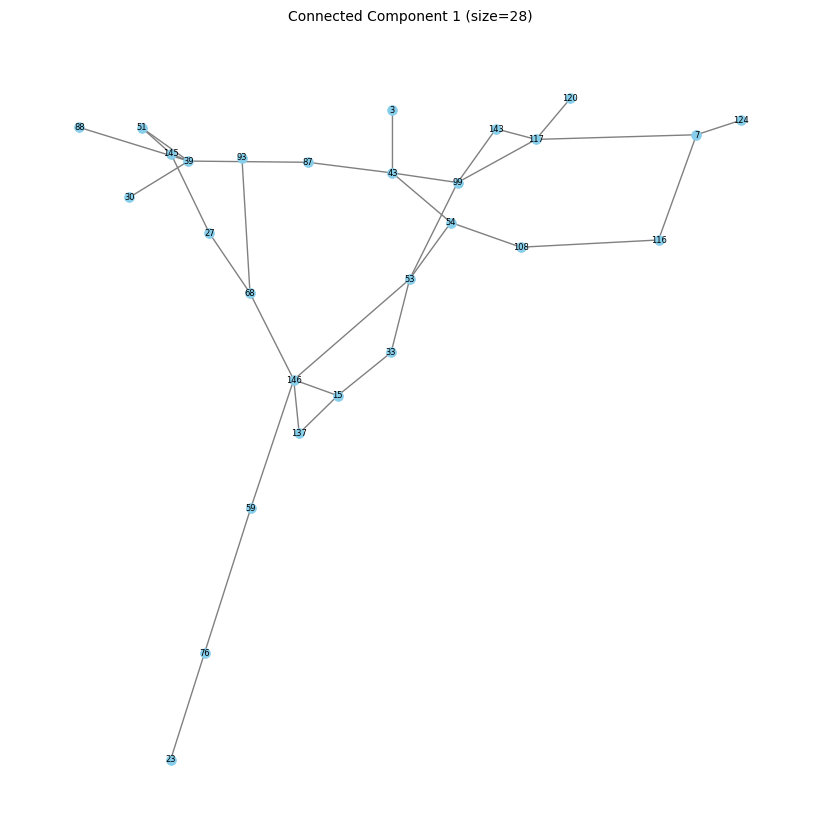

Displayed component 1 (|nodes| = 28)


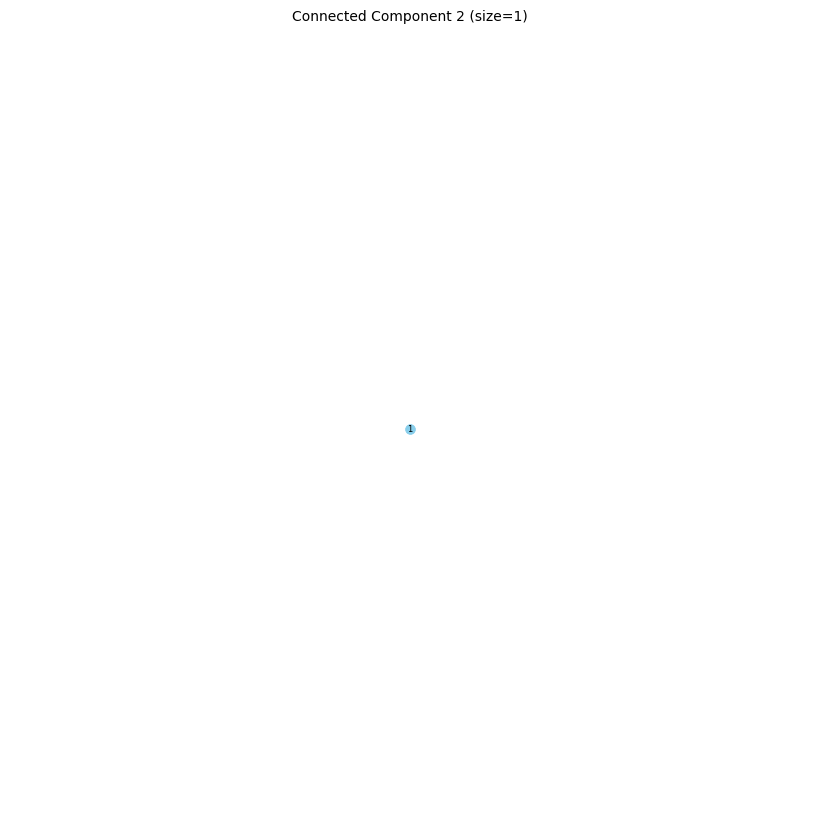

Displayed component 2 (|nodes| = 1)


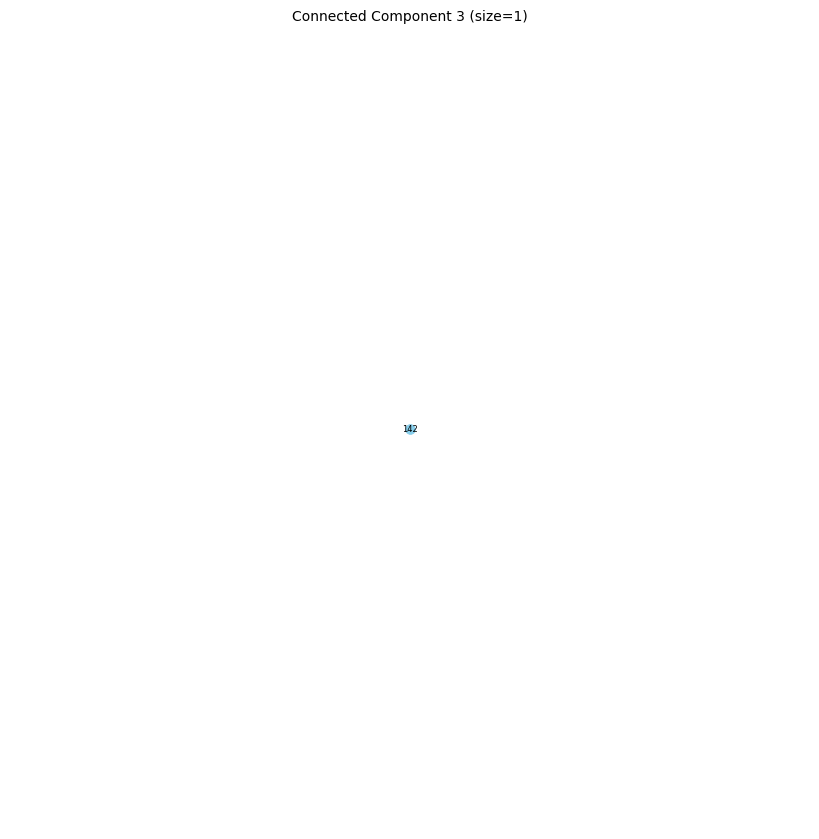

Displayed component 3 (|nodes| = 1)


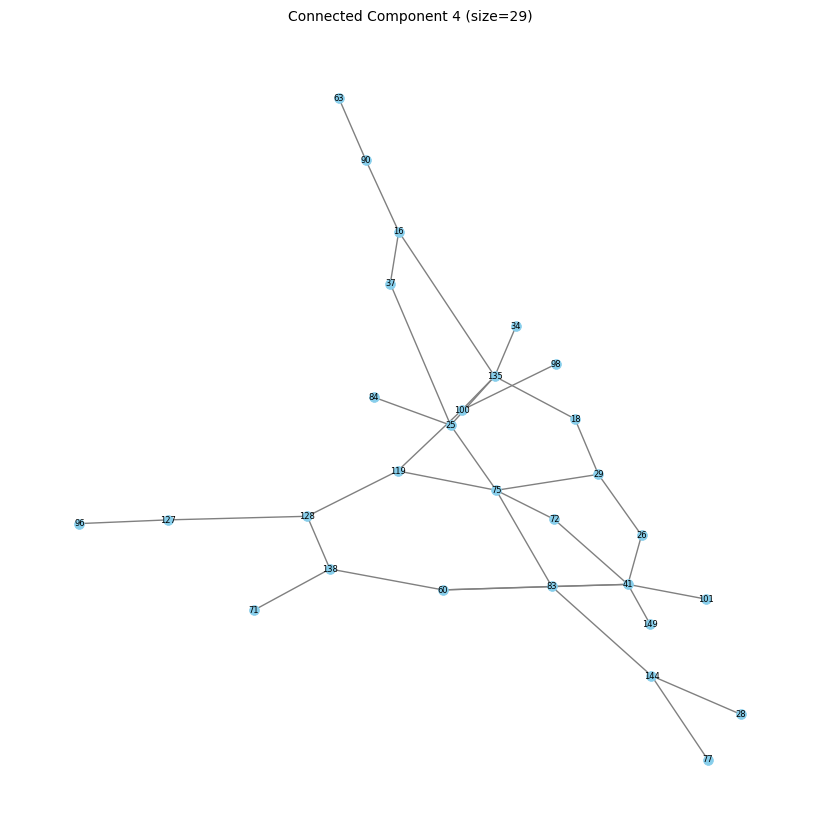

Displayed component 4 (|nodes| = 29)


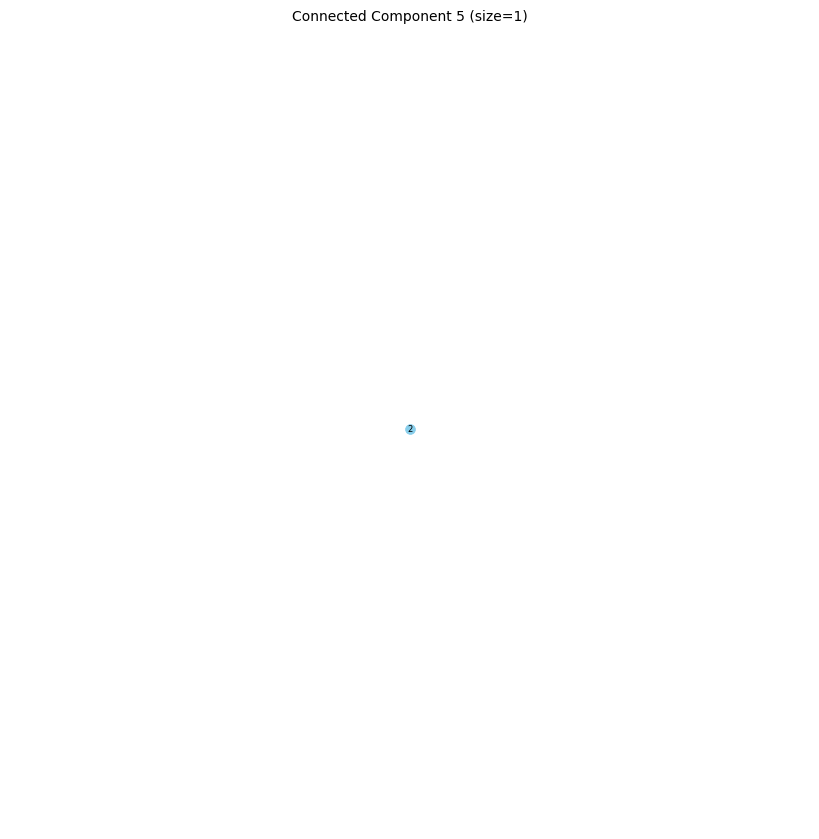

Displayed component 5 (|nodes| = 1)


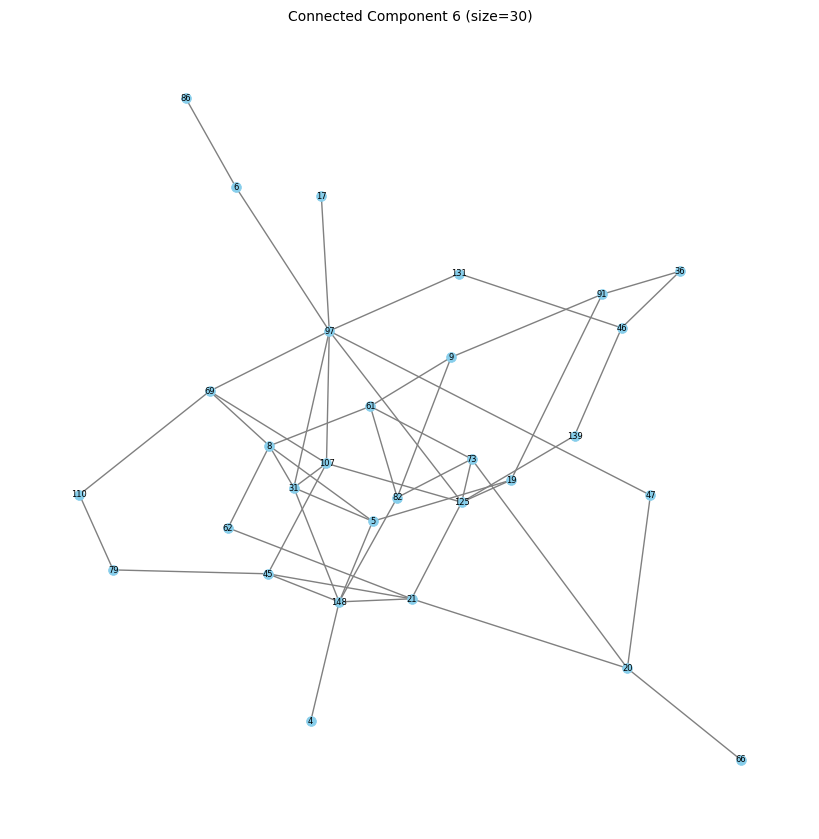

Displayed component 6 (|nodes| = 30)


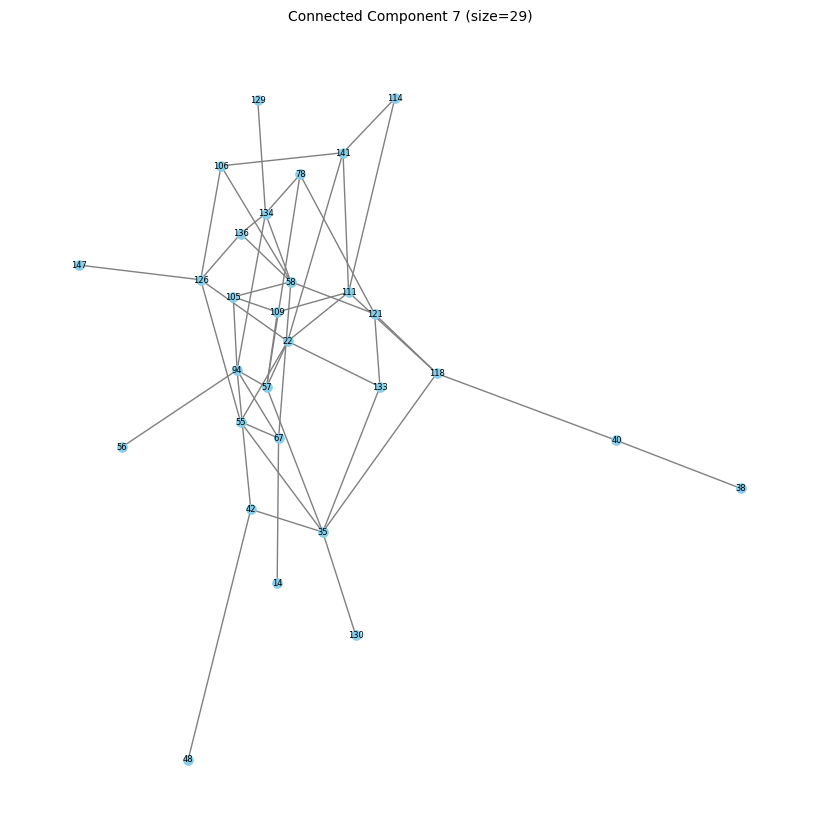

Displayed component 7 (|nodes| = 29)


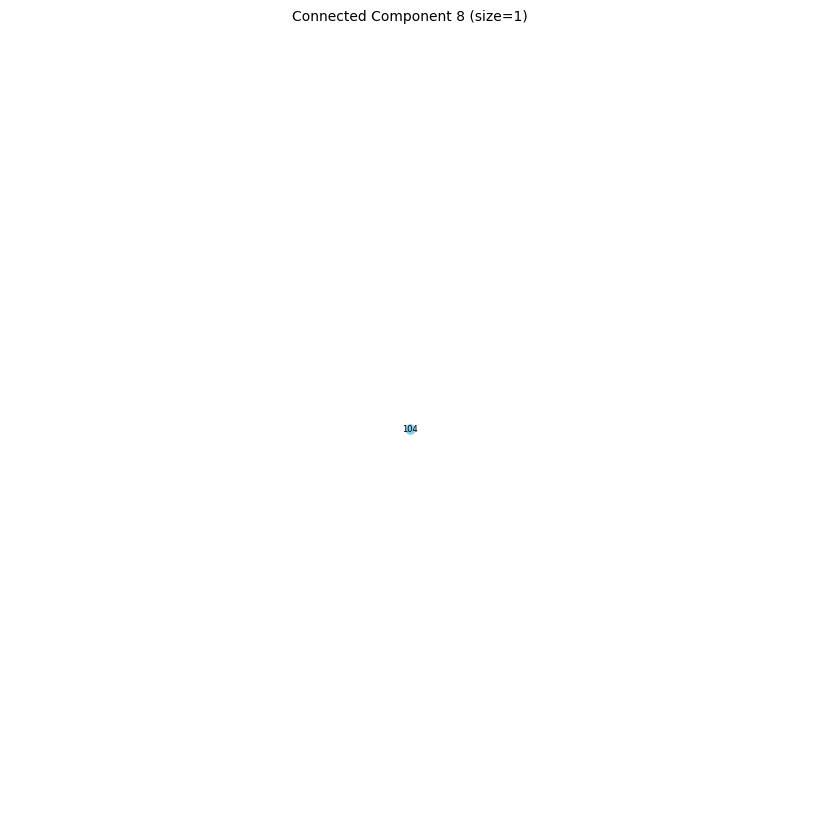

Displayed component 8 (|nodes| = 1)


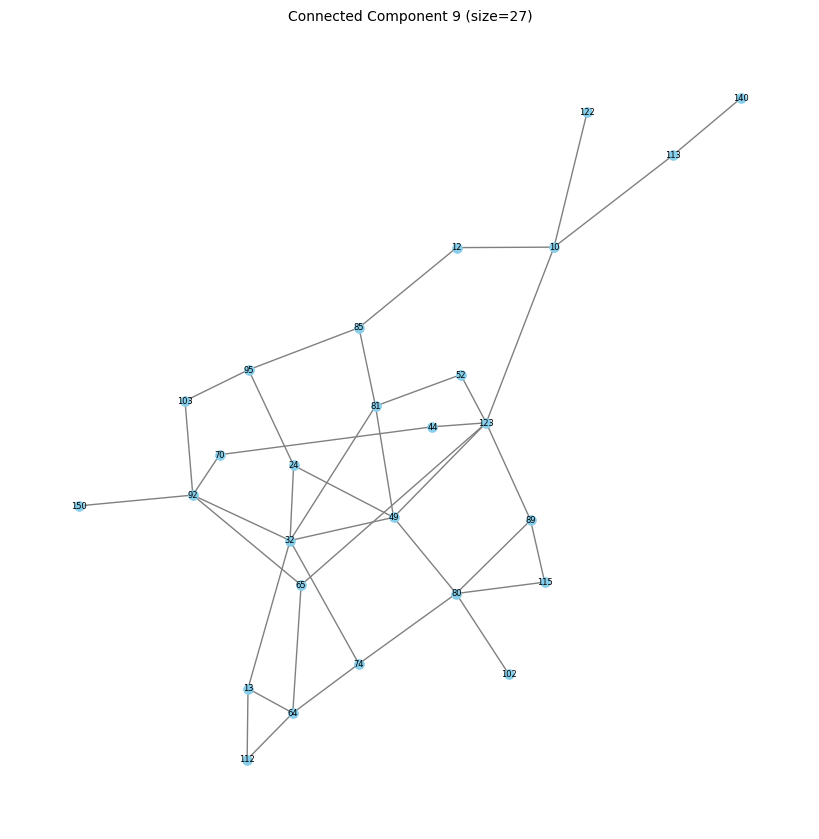

Displayed component 9 (|nodes| = 27)


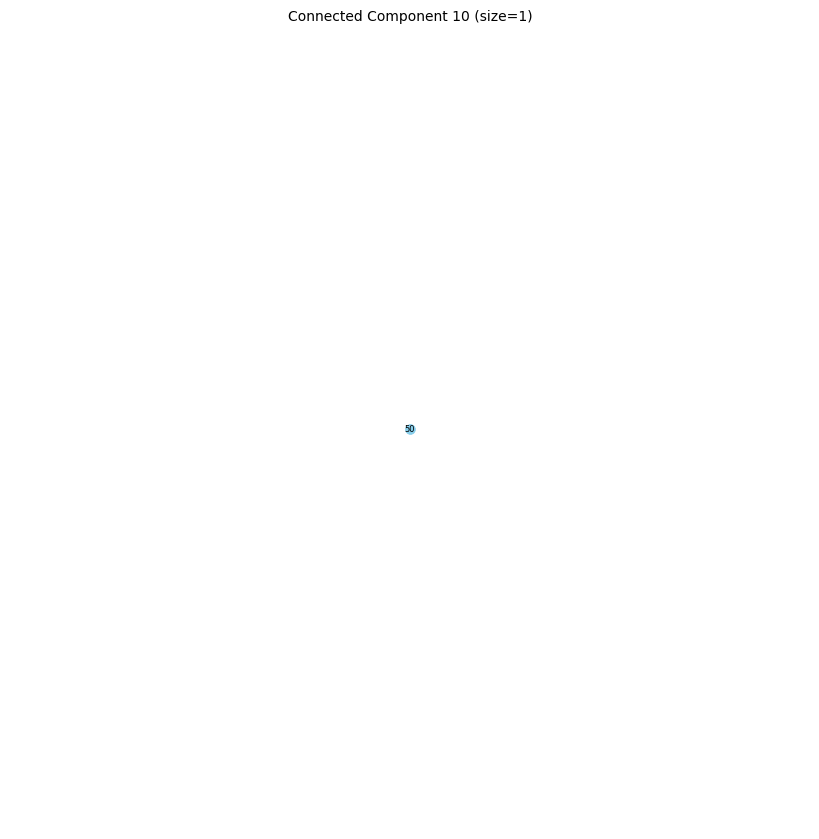

Displayed component 10 (|nodes| = 1)


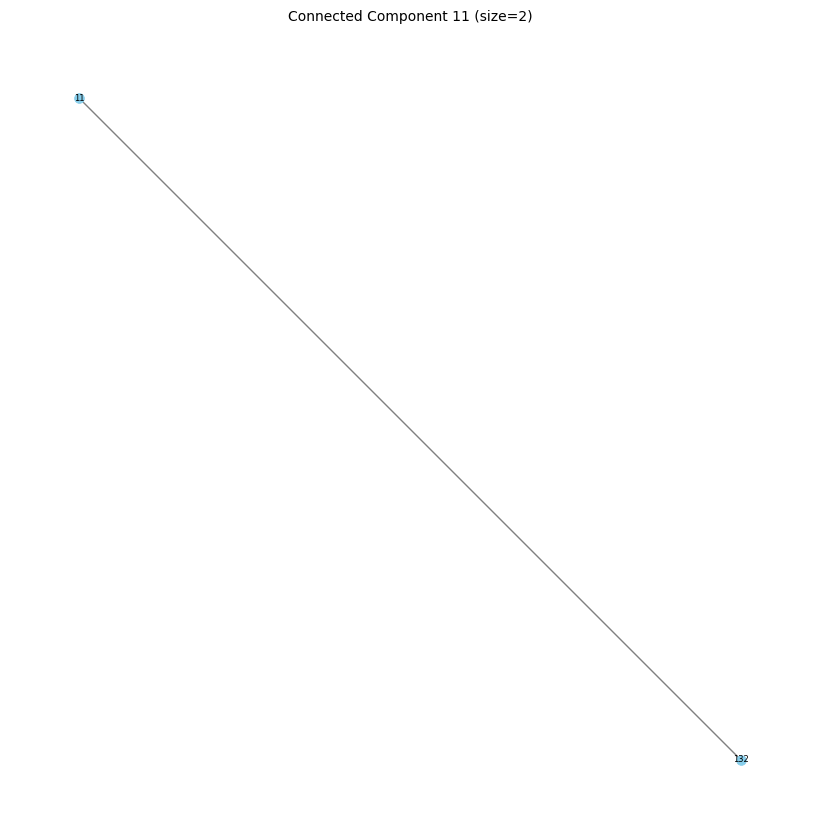

Displayed component 11 (|nodes| = 2)


In [33]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_components(G, figsize=(8, 8), dpi=100):
    """
    For each connected component in G, create and display a separate plot
    directly in the notebook output.

    Parameters:
    -----------
    G : networkx.Graph
        The full friendship graph.
    figsize : tuple
        Figure size in inches (width, height).
    dpi : int
        Resolution in dots per inch for each displayed figure.
    """
    # 1. Extract all connected components
    components = list(nx.connected_components(G))

    for idx, comp_nodes in enumerate(components, start=1):
        # 2. Build the subgraph for this component
        subG = G.subgraph(comp_nodes)

        # 3. Choose a layout (spring_layout tends to be fairly "clear")
        pos = nx.spring_layout(subG, seed=42)

        # 4. Plot the subgraph
        plt.figure(figsize=figsize, dpi=dpi)
        nx.draw(
            subG,
            pos,
            with_labels=True,
            node_size=50,
            font_size=6,
            edge_color="gray",
            node_color="skyblue",
            linewidths=0.5
        )
        plt.title(f"Connected Component {idx} (size={len(comp_nodes)})", fontsize=10)
        plt.axis("off")
        plt.tight_layout()

        # 5. Display the plot in the notebook
        plt.show()

        print(f"Displayed component {idx} (|nodes| = {len(comp_nodes)})")


# Example usage
if __name__ == "__main__":
    # Suppose G is your generated friendship graph:
    #   G, sections_map, popular_set = generate_social_network(...)
    #
    # Then simply call:
    #
    #   plot_components(G)
    #
    # This will display all components directly in the notebook output
    #
    plot_components(G)